# CNN Classification task using PyTorch on MNIST dataset

## `1.` Import needed libraries

In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

from torchsummary import summary

## `2.` Load the data


In [2]:
data_transform = transforms.Compose([
            transforms.Resize((32,32)) ,
            transforms.ToTensor(),
            transforms.Normalize((0.5,),(0.5,))])

In [3]:
train_set = datasets.MNIST(root = './data' , train = True , download= True , transform= data_transform)
train_loader =DataLoader(train_set , batch_size= 64 , shuffle= True , drop_last=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11599155.46it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 343758.53it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3233273.60it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4542329.22it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
test_set = datasets.MNIST(root = './data' , train = False , download= True , transform= data_transform)
test_loader =DataLoader(test_set , batch_size= 64 , shuffle= False , drop_last=True)

In [5]:
for batch_idx, (data, target) in enumerate(train_loader):
    print(f"Input shape: {data.shape}, Target shape: {target.shape}")
    break

Input shape: torch.Size([64, 1, 32, 32]), Target shape: torch.Size([64])


### plot samples of data

In [6]:
def plot_samples(samples):
  '''
  This function plots the first 9 samples form the passed dataset
  ----------------------------------
  parameters:
  samples : the dataset you want to plot samples from it

  '''
  plt.figure(figsize=(12,8))
  for i in range(9):
    plt.subplot(3, 3 , i+1)
    plt.imshow(samples[i].permute(1,2,0) , cmap = 'gray')
    plt.axis('off')

  plt.tight_layout()
  plt.show();

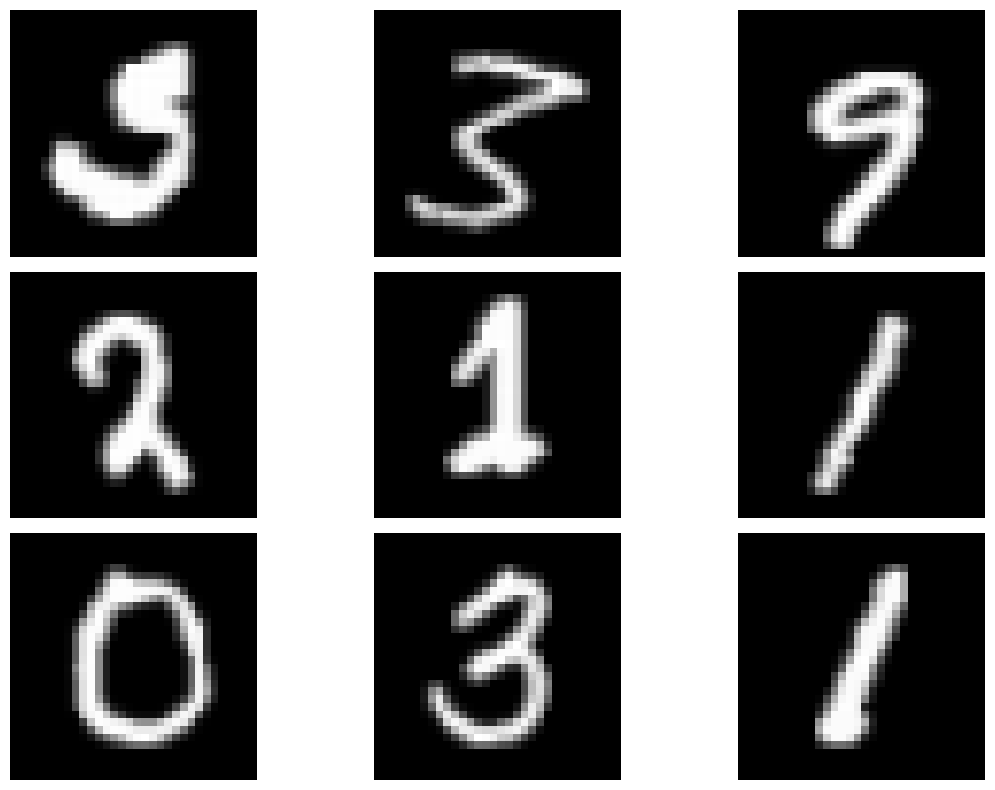

In [7]:
for batch in train_loader:
  images , labels = batch
  plot_samples(images)
  break

## `3.` Model building

### `Custom CNN architecture`

In [8]:
class Custom_CNN(nn.Module):
    def __init__(self, activation='relu', pooling='max', dropout_prob=0.0):
        super(Custom_CNN, self).__init__()
        self.activation_fn = {
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'relu': nn.ReLU()
        }
        self.pooling_fn = {
            'max': nn.MaxPool2d(kernel_size=2, stride=2),
            'avg': nn.AvgPool2d(kernel_size=2, stride=2)
        }

        self.dropout = nn.Dropout(dropout_prob)
        self.activation = activation
        self.pooling = pooling

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        self.pool = self.pooling_fn[self.pooling]

        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation_fn[self.activation](x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.activation_fn[self.activation](x)
        x = self.pool(x)
        x = x.view(-1, 32 * 8* 8)
        x = self.fc1(x)
        x = self.activation_fn[self.activation](x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

### `LeNet5 architecture `

In [9]:
class LeNet5(nn.Module):
    def __init__(self , activation = 'relu' , pooling = 'max' , dropout_prob = 0.0):
        super(LeNet5, self).__init__()
        self.activation_fn = {
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'relu': nn.ReLU()
            }
        self.pooling_fn = {
                'max': nn.MaxPool2d(kernel_size=2, stride=2),
                'avg': nn.AvgPool2d(kernel_size=2, stride=2)
            }

        self.dropout = nn.Dropout(dropout_prob)
        self.activation = activation
        self.pooling = pooling

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

        # Average Pooling layer
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pooling_fn[self.pooling](self.activation_fn[self.activation](self.conv1(x)))
        x = self.pooling_fn[self.pooling](self.activation_fn[self.activation](self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.dropout(self.activation_fn[self.activation](self.fc1(x)))
        x = self.dropout(self.activation_fn[self.activation](self.fc2(x)))
        x = self.fc3(x)
        return x

## `4.` Model training

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
cnn_model = Custom_CNN(activation= 'tanh' , pooling= 'avg', dropout_prob = 0.3 ).to(device)
summary(cnn_model ,(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             160
         AvgPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         AvgPool2d-4             [-1, 32, 8, 8]               0
            Linear-5                  [-1, 128]         262,272
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 268,362
Trainable params: 268,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 1.02
Estimated Total Size (MB): 1.26
----------------------------------------------------------------


In [12]:
lenet_model = LeNet5(activation= 'tanh' , pooling= 'avg', dropout_prob = 0.3).to(device)
summary(lenet_model , input_size=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
           Dropout-4                  [-1, 120]               0
            Linear-5                   [-1, 84]          10,164
           Dropout-6                   [-1, 84]               0
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


In [13]:
num_epochs = 50
criterion = nn.CrossEntropyLoss()

In [14]:
def model_train(model, device, train_loader,test_loader, optimizer, criterion, epochs):
    model.train()

    train_losses = []
    test_accuracies = []
    test_loss = 0
    test_losses = []

    optimizers = {
        'adam': torch.optim.Adam(model.parameters()),
        'SGD' : torch.optim.SGD(model.parameters()),
        'RMSProp' : torch.optim.RMSprop(model.parameters())}

    for epoch in range(epochs):
        train_loss = 0
        num_batches = len(train_loader)
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizers[optimizer].zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizers[optimizer].step()

            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}, Loss: {loss.item()}")
            train_loss += loss.item()

        train_losses.append(train_loss/len(train_loader))

        test_loss , accuracy = evaluate_model(model, device, test_loader)
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")
        test_losses.append(test_loss)
        test_accuracies.append(accuracy)

    visualize_results(train_losses , test_accuracies , epochs)
    return train_losses, test_losses , test_accuracies

## `5.` Model evaluation

In [15]:
def evaluate_model(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    return test_loss / len(test_loader), accuracy

## `6.` Visualizing results

In [16]:
def visualize_results(losses, accuracies, epochs):
    plt.figure(figsize=(10, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), losses)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss')

    # Plot test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), accuracies)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Test Accuracy')

    plt.tight_layout()
    plt.show()


# `i` Model process

In [17]:
torch.manual_seed(42)

## CNN trainnig:

In [18]:
for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    output = cnn_model(data)
    print("Output shape:", output.shape)
    print("Target shape:", target.shape)
    break


Output shape: torch.Size([64, 10])
Target shape: torch.Size([64])


Epoch 1, Batch 100, Loss: 2.63787579536438
Epoch 1, Batch 200, Loss: 2.881208896636963
Epoch 1, Batch 300, Loss: 2.4443905353546143
Epoch 1, Batch 400, Loss: 3.326935291290283
Epoch 1, Batch 500, Loss: 2.6361677646636963
Epoch 1, Batch 600, Loss: 2.414900541305542
Epoch 1, Batch 700, Loss: 2.5192291736602783
Epoch 1, Batch 800, Loss: 2.463381052017212
Epoch 1, Batch 900, Loss: 2.4381046295166016
Epoch 1, Loss: 2.9681, Accuracy: 9.81%
Epoch 2, Batch 100, Loss: 2.3557724952697754
Epoch 2, Batch 200, Loss: 2.476717233657837
Epoch 2, Batch 300, Loss: 2.494762420654297
Epoch 2, Batch 400, Loss: 2.7765119075775146
Epoch 2, Batch 500, Loss: 2.451458692550659
Epoch 2, Batch 600, Loss: 2.5604958534240723
Epoch 2, Batch 700, Loss: 2.517751932144165
Epoch 2, Batch 800, Loss: 2.778515100479126
Epoch 2, Batch 900, Loss: 2.459573268890381
Epoch 2, Loss: 2.3077, Accuracy: 9.75%
Epoch 3, Batch 100, Loss: 2.653637647628784
Epoch 3, Batch 200, Loss: 2.9159817695617676
Epoch 3, Batch 300, Loss: 2.7852888

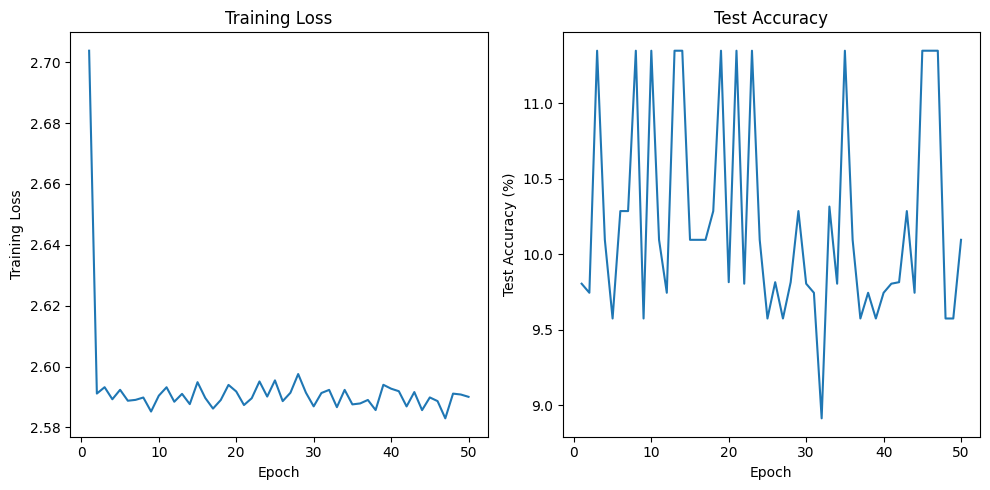

In [19]:
cnn_losses, cnn_test_losses, cnn_accuracies = model_train(cnn_model, device, train_loader, test_loader, 'RMSProp', criterion, num_epochs)

## LeNet trainnig:

In [20]:
for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    output = lenet_model(data)
    print("Output shape:", output.shape)
    print("Target shape:", target.shape)
    break


Output shape: torch.Size([64, 10])
Target shape: torch.Size([64])


Epoch 1, Batch 100, Loss: 0.6667271256446838
Epoch 1, Batch 200, Loss: 0.334354966878891
Epoch 1, Batch 300, Loss: 0.4267907440662384
Epoch 1, Batch 400, Loss: 0.30546149611473083
Epoch 1, Batch 500, Loss: 0.44703105092048645
Epoch 1, Batch 600, Loss: 0.29746443033218384
Epoch 1, Batch 700, Loss: 0.23514783382415771
Epoch 1, Batch 800, Loss: 0.6028047204017639
Epoch 1, Batch 900, Loss: 0.2213379591703415
Epoch 1, Loss: 0.3592, Accuracy: 94.95%
Epoch 2, Batch 100, Loss: 0.10943811386823654
Epoch 2, Batch 200, Loss: 0.1819518506526947
Epoch 2, Batch 300, Loss: 0.1299929916858673
Epoch 2, Batch 400, Loss: 0.24925075471401215
Epoch 2, Batch 500, Loss: 0.3885580897331238
Epoch 2, Batch 600, Loss: 0.23866328597068787
Epoch 2, Batch 700, Loss: 0.19188135862350464
Epoch 2, Batch 800, Loss: 0.2576158344745636
Epoch 2, Batch 900, Loss: 0.316752552986145
Epoch 2, Loss: 0.1389, Accuracy: 94.64%
Epoch 3, Batch 100, Loss: 0.17730103433132172
Epoch 3, Batch 200, Loss: 0.029121922329068184
Epoch 3, Ba

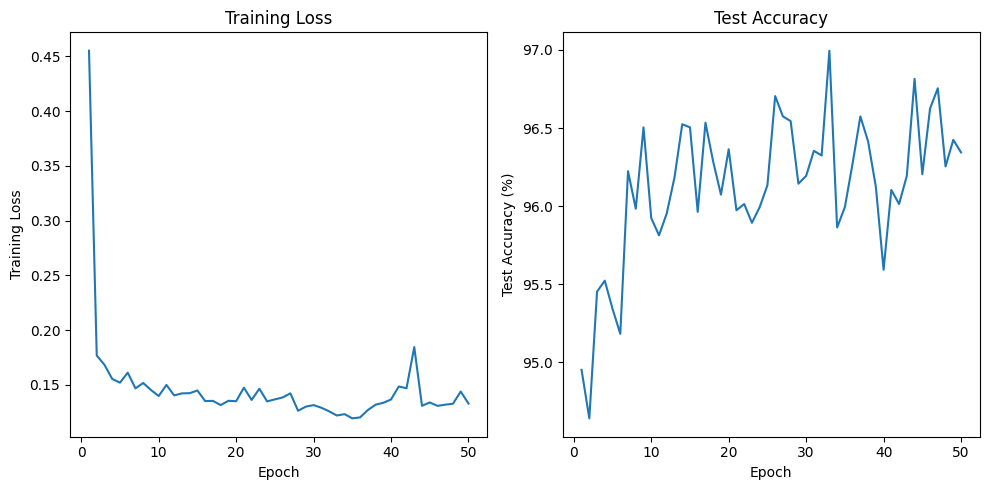

In [22]:
lenet_losses, lenet_test_losses, lenet_accuracies = model_train(lenet_model, device, train_loader, test_loader, 'RMSProp', criterion, num_epochs)

## Trying different approaches:

In [23]:
cnn_model = Custom_CNN(activation = 'tanh' , pooling = 'max' , dropout_prob = 0.1).to(device)
summary(cnn_model , (1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             160
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Linear-5                  [-1, 128]         262,272
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 10]           1,290
Total params: 268,362
Trainable params: 268,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 1.02
Estimated Total Size (MB): 1.26
----------------------------------------------------------------


Epoch 1, Batch 100, Loss: 2.688359498977661
Epoch 1, Batch 200, Loss: 2.3687362670898438
Epoch 1, Batch 300, Loss: 2.6534347534179688
Epoch 1, Batch 400, Loss: 2.4967899322509766
Epoch 1, Batch 500, Loss: 2.4813010692596436
Epoch 1, Batch 600, Loss: 2.442373514175415
Epoch 1, Batch 700, Loss: 2.4477920532226562
Epoch 1, Batch 800, Loss: 2.7202961444854736
Epoch 1, Batch 900, Loss: 2.4232709407806396
Epoch 1, Loss: 2.3445, Accuracy: 10.32%
Epoch 2, Batch 100, Loss: 2.7126667499542236
Epoch 2, Batch 200, Loss: 2.6251919269561768
Epoch 2, Batch 300, Loss: 2.3644607067108154
Epoch 2, Batch 400, Loss: 2.7427475452423096
Epoch 2, Batch 500, Loss: 2.634587526321411
Epoch 2, Batch 600, Loss: 2.5738465785980225
Epoch 2, Batch 700, Loss: 2.490281581878662
Epoch 2, Batch 800, Loss: 2.5291104316711426
Epoch 2, Batch 900, Loss: 2.8353075981140137
Epoch 2, Loss: 2.5499, Accuracy: 9.81%
Epoch 3, Batch 100, Loss: 2.562223434448242
Epoch 3, Batch 200, Loss: 2.84867000579834
Epoch 3, Batch 300, Loss: 2.

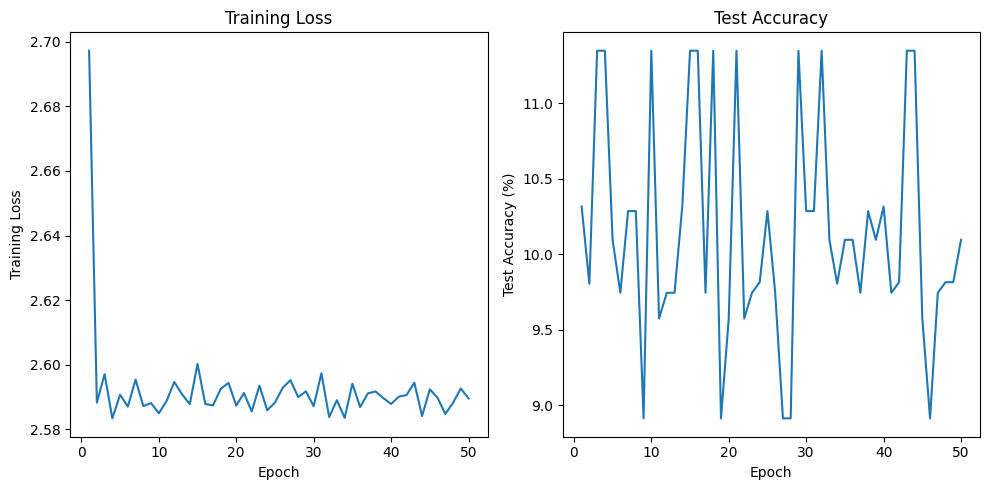

In [24]:
cnn_losses, cnn_test_losses, cnn_accuracies = model_train(cnn_model, device, train_loader, test_loader, 'RMSProp', criterion, num_epochs)

In [25]:
lenet_model = LeNet5(activation = 'tanh' , pooling = 'max' , dropout_prob = 0.1).to(device)
summary(lenet_model , (1 , 32 ,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
           Dropout-4                  [-1, 120]               0
            Linear-5                   [-1, 84]          10,164
           Dropout-6                   [-1, 84]               0
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


Epoch 1, Batch 100, Loss: 0.4785176217556
Epoch 1, Batch 200, Loss: 0.33974573016166687
Epoch 1, Batch 300, Loss: 0.20069670677185059
Epoch 1, Batch 400, Loss: 0.27873754501342773
Epoch 1, Batch 500, Loss: 0.22518901526927948
Epoch 1, Batch 600, Loss: 0.37603816390037537
Epoch 1, Batch 700, Loss: 0.14964726567268372
Epoch 1, Batch 800, Loss: 0.1656876504421234
Epoch 1, Batch 900, Loss: 0.06529230624437332
Epoch 1, Loss: 0.1927, Accuracy: 95.04%
Epoch 2, Batch 100, Loss: 0.08561111241579056
Epoch 2, Batch 200, Loss: 0.15656255185604095
Epoch 2, Batch 300, Loss: 0.18420587480068207
Epoch 2, Batch 400, Loss: 0.0721273124217987
Epoch 2, Batch 500, Loss: 0.11589908599853516
Epoch 2, Batch 600, Loss: 0.1035989373922348
Epoch 2, Batch 700, Loss: 0.04011768475174904
Epoch 2, Batch 800, Loss: 0.1590784639120102
Epoch 2, Batch 900, Loss: 0.2673264741897583
Epoch 2, Loss: 0.4228, Accuracy: 95.12%
Epoch 3, Batch 100, Loss: 0.145050510764122
Epoch 3, Batch 200, Loss: 0.13339267671108246
Epoch 3, Ba

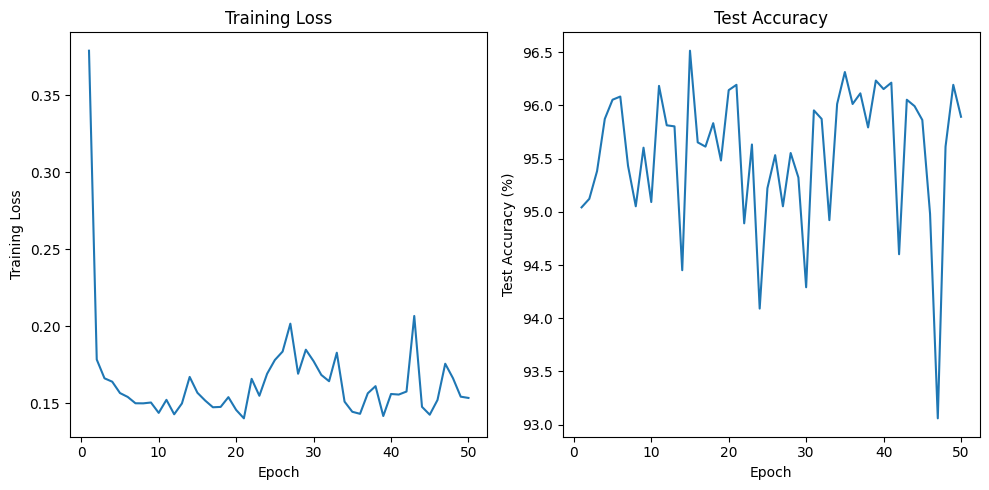

In [26]:
lenet_losses, lenet_test_losses, lenet_accuracies = model_train(lenet_model, device, train_loader, test_loader, 'RMSProp', criterion, num_epochs)